<a href="https://colab.research.google.com/github/AnnabelleBlangero/TeachingRespAI/blob/main/Teaching_Notebook_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NoteBook Titanic

# Importation des librairies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install shap
import shap
import warnings
warnings.filterwarnings('ignore')
!pip install fairlearn
from fairlearn.metrics import selection_rate, MetricFrame

## AIF360
!pip install aif360 
from typing import List, Union, Dict
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing  # Preprocessing technique

from sklearn import preprocessing, tree
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV,
                                     KFold,                                     
                                     learning_curve, 
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.8 MB/s 


pip install 'aif360[LawSchoolGPA]'


# Chargement & vérification des données

In [2]:
data_titanic = pd.read_csv("./Data_Titanic.csv")

On procède d'abord à une première analyse visuelle des données :

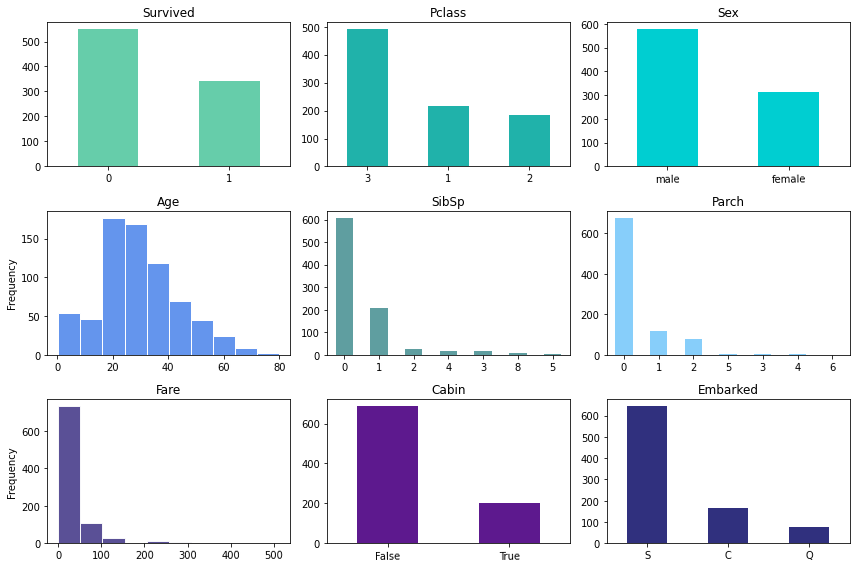

In [3]:
fig, ax = plt.subplots(3,3, figsize = (12,8))

# Nb survivants
_ = data_titanic.Survived.value_counts().plot(kind = 'bar',
                                              subplots = True, 
                                              ax = ax[0,0],
                                              rot = 1,
                                              color = 'mediumaquamarine')
# Nb passagers des différentes classes
_ = data_titanic.Pclass.value_counts().plot(kind = 'bar',
                                            subplots = True,
                                            ax = ax[0,1],
                                            rot = 1,
                                            color = 'lightseagreen')
# Nb d'Hommes et de Femmes
_ = data_titanic.Sex.value_counts().plot(kind = 'bar',
                                         subplots = True,
                                         ax = ax[0,2],
                                         rot = 1,
                                         color = 'darkturquoise')
# Distribution des âges
_ = data_titanic.Age.plot(kind = 'hist',
                          subplots = True,
                          ax = ax[1,0],
                          rot = 1,
                          color = 'cornflowerblue', 
                          edgecolor = 'w')
ax[1,0].title.set_text('Age')

# Nb d'accompagnants (Frères/Soeurs, Epoux/Epouses)
_ = data_titanic.SibSp.value_counts().plot(kind = 'bar',
                                           subplots = True,
                                           ax = ax[1,1],
                                           rot = 1,
                                           color = 'cadetblue')

# Nb d'accompagnants (Parents, Enfants)
_ = data_titanic.Parch.value_counts().plot(kind = 'bar',
                                           subplots = True,
                                           ax = ax[1,2],
                                           rot = 1,
                                           color = 'lightskyblue')

# Répartition prix tickets
_ = data_titanic.Fare.plot(kind = 'hist',                           
                           subplots = True,
                           ax = ax[2,0],
                           rot = 1,
                           color = 'darkslateblue',
                           alpha = 0.9, 
                           edgecolor = 'w')
ax[2,0].title.set_text('Fare')

# Nb de passagers avec ou sans cabine
_ = data_titanic.Cabin.notnull().value_counts().plot(kind = 'bar',
                                                     subplots = True,
                                                     ax = ax[2,1],
                                                     rot = 1,
                                                     color = 'indigo',
                                                     alpha = 0.9)

# Nb de passagers selon le port d'embarquement
_ = data_titanic.Embarked.value_counts().plot(kind = 'bar',
                                              subplots = True,
                                              ax = ax[2,2],
                                              rot = 1,
                                              color = 'midnightblue',
                                              alpha = 0.9)

fig.tight_layout()

Grâce à cette première analyse visuelle, on constate que la répartition des individus est inégale que ce soit pour la classe sociale, le sexe ou bien le port d'embarquement.

On vérifie l'existence d'outliers dans nos variables :

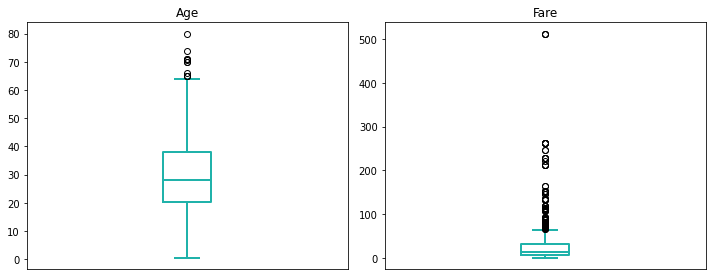

In [4]:
boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen',  linewidth = 2)
whiskerprops = dict(color = 'lightseagreen',  linewidth = 2)
capprops = dict(color = 'lightseagreen',  linewidth = 2)

fig, ax = plt.subplots(1, 2, figsize = (10,4))

# BoxPlot des Ages
age = data_titanic.loc[data_titanic['Age'].notnull(), 'Age']

_ = age.plot(kind = 'box',
         ax = ax[0], 
         title = 'Age', 
         boxprops = boxprops, 
         whiskerprops = whiskerprops, 
         capprops = capprops, 
         medianprops = medianprops)

# BoxPlot du prix du ticket
_ = data_titanic['Fare'].plot(kind = 'box',
                              ax = ax[1], 
                              title = 'Fare', 
                              boxprops = boxprops, 
                              whiskerprops = whiskerprops, 
                              capprops = capprops, 
                              medianprops = medianprops)

_ = ax[0].axes.xaxis.set_ticks([])
_ = ax[1].axes.xaxis.set_ticks([])

fig.tight_layout()

Les variables contiennent des outliers. Ainsi, lors de la standardisation on devra faire attention à utiliser un Scaler qui n'est pas sensible aux outliers. 
Si pour la variable Age les valeurs semblent cohérentes, certaines valeurs de la variable Fare semblent très dispersées. On reviendra là-dessus dans la partie amélioration des Features.

# Préparation & nettoyage des données
On supprime les éventuels doublons :

In [5]:
data_titanic.drop_duplicates(inplace = True)

### Gestion des valeurs manquantes

Tout d'abord, on vérifie  le nombre d'observation dans chaque variable : 

In [6]:
data_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [7]:
data_titanic.isna().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Il manque 177 valeurs dans la variable Age, 687 dans la variable Cabin et 2 dans la variable Embarked. Contrairement à la variable Age, on peut considérer que le nombre de valeurs manquantes dans la variable Cabin est trop important pour pouvoir effectuer une imputation. On va donc supprimer cette variable. On aurait pu aussi transformer la variable en CabinMissing afin de garder de l'information. Les deux passagers pour lesquels les valeurs Embarked sont manquantes seront supprimés.

### Création d'un nouveau dataframe

Afin d'éviter tout data leakage, on va créer un nouveau dataframe sur lequel on va effectuer toutes les modifications. Ainsi, on conserve les data dans leur état initial : 

In [8]:
data_transformed = data_titanic[['Survived','Pclass',
                                 'Sex', 'Age', 'SibSp',
                                 'Parch', 'Ticket',
                                 'Fare', 'Embarked']].copy()

On supprime les deux lignes où l'information du port d'embarcation est manquante :

In [9]:
data_transformed.dropna(axis = 0,
                        how = 'any',
                        subset = ['Embarked'],
                        inplace = True)

data_transformed = data_transformed.reset_index()

In [10]:
data_transformed.head()

,index,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,3,1,1,female,35.0,1,0,113803,53.1000,S
4,4,0,3,male,35.0,0,0,373450,8.0500,S


# Amélioration des features
### Imputation des âges
Concernant la variable Age, beaucoup de données sont manquantes. Toutefois, la variable Age sera utile pour le modèle. On réalise donc une imputation des âges manquants : 

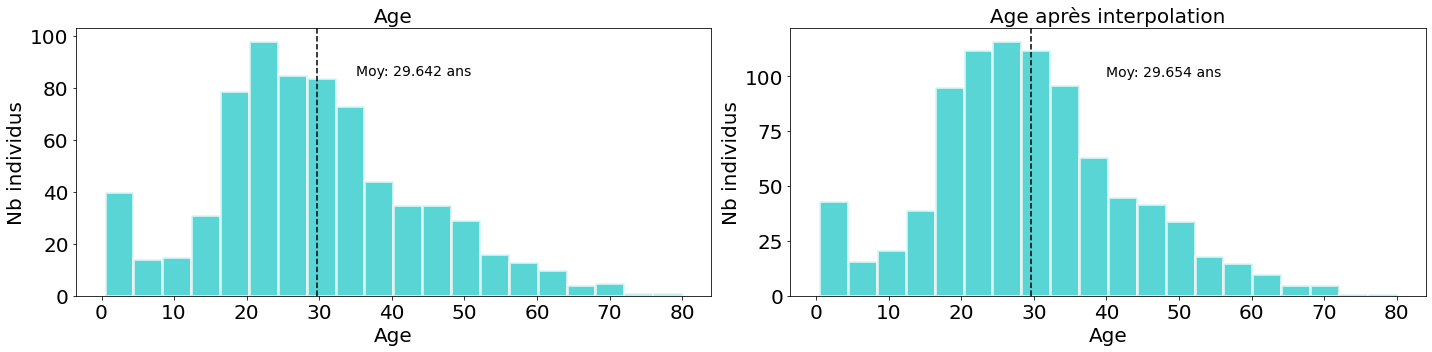

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (20,5))
 
# Je fais une interpolation des Age    
data_transformed['age_interpolate'] = data_transformed['Age'].interpolate()

# Je plot les deux variables pour voir l'effet de l'interpolation

# Age avant interpolation
_ = ax[0].hist(data_transformed['Age'],
               bins = 20, 
               color = 'c', 
               edgecolor = 'w',
               linewidth = 3,
               alpha = 0.65)

_ = ax[0].axvline(data_transformed['Age'].mean(), 
                  color = 'k', 
                  linestyle = 'dashed')

ax[0].set_title('Age', fontsize = 20)
ax[0].tick_params(axis = 'x', labelsize = 20)
ax[0].tick_params(axis = 'y', labelsize = 20)
ax[0].set_xlabel('Age', fontsize = 20)
ax[0].set_ylabel('Nb individus', fontsize = 20)
ax[0].text(35, 85, f"Moy: {np.round(data_transformed['Age'].mean(),3)} ans", fontsize = 14)

# Age après interpolation
_ = ax[1].hist(data_transformed['age_interpolate'], 
               bins = 20, 
               color = 'c', 
               edgecolor = 'w',
               linewidth = 3,
               alpha = 0.65)

_ = ax[1].axvline(data_transformed['age_interpolate'].mean(), 
                  color = 'k',
                  linestyle = 'dashed')

_ = ax[1].set_title('Age après interpolation',
                    fontsize = 20)

ax[1].tick_params(axis = 'x', labelsize = 20)
ax[1].tick_params(axis = 'y', labelsize = 20)
ax[1].set_xlabel('Age', fontsize = 20)
ax[1].set_ylabel('Nb individus', fontsize = 20)
ax[1].text(40, 100, f"Moy: {np.round(data_transformed['age_interpolate'].mean(),3)} ans", fontsize = 14)

fig.tight_layout()

### Discrétisation des données - Création d'une colonne classe d'âge
Vu l'époque, on peut dire qu'en dessous de 16 ans l'individu est considéré comme un enfant, et qu'au delà de 50 ans on le considère comme vieux.

In [12]:
# Définition d'une fonction pour classer les âges
def classifier(age):
    if age < 16: 
        return('enfant')
    elif age >= 16 and age < 50 :
        return('jeune')
    else :
        return('vieux')

# Application de la fonction de classification sur la colonne Age du df
data_transformed['age_class'] = (data_transformed['age_interpolate']
                                 .map(lambda x: classifier(x)))

### Extraction de la valeur du numéro de ticket
Les tickets sont composés d'une chaine de caractère et d'un numéro. On peut récupérer uniquement le numéro pour pouvoir l'utiliser ensuite dans le modèle : 

In [13]:
# Définition d'une fonction pour séparer les strings
def separate(chaine):
    if chaine == 'LINE': # certains tickets sont manquants et correspondent à LINE 
        return(0)
    else :
        return(int(chaine.split()[-1])) # on split à l'espace
                                            # on ne garde que le dernier élément

# Création d'une nouvelle colonne contenant que le numéro de Ticket
data_transformed['ticket_number'] = data_transformed['Ticket'].map(lambda x: separate(x))

On regarde la distribution des numéros de ticket pour vérifier qu'il n'y ait pas d'outliers : 

Nombre d'outliers dans les numéros de tickets : 44


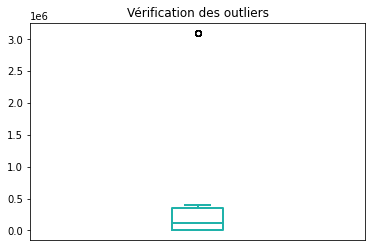

In [14]:
boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen',  linewidth = 2)
whiskerprops = dict(color = 'lightseagreen',  linewidth = 2)
capprops = dict(color = 'lightseagreen',  linewidth = 2)

# BoxPlot des différents prix de tickets
ticket_number = data_transformed['ticket_number'].plot(kind = 'box', 
                                       figsize = (6,4), 
                                       boxprops = boxprops, 
                                       medianprops = medianprops, 
                                       whiskerprops = whiskerprops, 
                                       capprops = capprops)

_ = plt.title('Vérification des outliers')
_ = ticket_number.xaxis.set_ticks([])
    
fig.tight_layout()

print('Nombre d\'outliers dans les numéros de tickets :', 
      data_transformed.loc[data_transformed['ticket_number']>1000000,
                           'ticket_number'].count())

44 valeurs de tickets sont abérantes. On peut les remplacer en faisant une imputation pour ces valeurs.

In [16]:
# Suppression des outliers de la variable ticket
data_transformed.loc[data_transformed['ticket_number']>1000000,'ticket_number'] = np.nan

data_transformed['ticket_number_clean'] = data_transformed['ticket_number']

# Interpolation des tickets manquants
data_transformed['ticket_nb_intp'] = data_transformed['ticket_number_clean'].interpolate()

On vérifie que l'interpolation a bien fonctionné sans trop affecter la variable : 

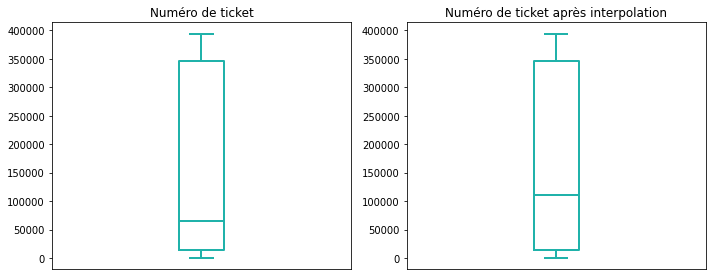

In [17]:
# Vérification de l'interpolation
boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen',  linewidth = 2)
whiskerprops = dict(color = 'lightseagreen',  linewidth = 2)
capprops = dict(color = 'lightseagreen',  linewidth = 2)

fig, ax = plt.subplots(1,2, figsize = (10,4))

# BoxPlot du numéro de ticket
data_transformed['ticket_number'].plot(kind = 'box',
                   ax = ax[0], 
                   title = 'Numéro de ticket', 
                   boxprops = boxprops, 
                   whiskerprops = whiskerprops, 
                   capprops = capprops, 
                   medianprops = medianprops)
                         
# BoxPlot du numéro de ticket après interpolation
data_transformed['ticket_nb_intp'].plot(kind = 'box',
                                        ax = ax[1],
                                        title = 'Numéro de ticket après interpolation',
                                        boxprops = boxprops, 
                                        whiskerprops = whiskerprops, 
                                        capprops = capprops, 
                                        medianprops = medianprops)
                                                    

ax[0].axes.xaxis.set_ticks([])
ax[1].axes.xaxis.set_ticks([])
              
fig.tight_layout()

### Division prix du ticket

Plus tôt, lors de la vérification des outliers, nous avons vu que la variable Fare est très dispersée. Le prix est compté pour l'ensemble des personnes de la famille pouvant ainsi expliquer cette dispersion. On choisis de diviser le prix du billet par le nombre total de personne de la famille (Epouse, Enfants, ...) : 


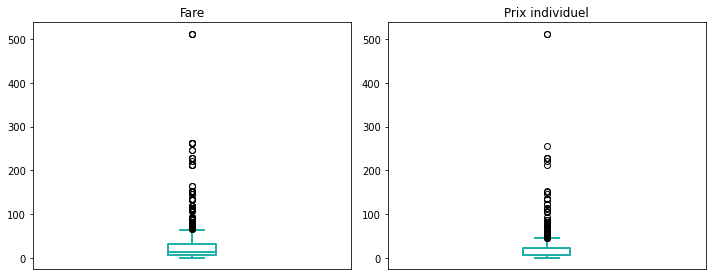

In [18]:
# Vérification de l'interpolation
data_transformed['prix_indiv'] = (data_transformed['Fare'] / 
                                  (1 + data_transformed['SibSp'] + 
                                   data_transformed['Parch']))

fig, ax = plt.subplots(1,2, figsize = (10,4))

boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen', linewidth = 2)
whiskerprops = dict(color = 'lightseagreen', linewidth = 2)
capprops = dict(color = 'lightseagreen', linewidth = 2)

# BoxPlot du prix global 
data_transformed['Fare'].plot(kind = 'box', 
                              ax = ax[0],
                              title = 'Fare',
                              boxprops = boxprops, 
                              whiskerprops = whiskerprops, 
                              capprops = capprops, 
                              medianprops = medianprops)

# BoxPlot du prix individuel
data_transformed['prix_indiv'].plot(kind = 'box', 
                                    ax = ax[1],
                                    title = 'Prix individuel',
                                    boxprops = boxprops, 
                                    whiskerprops = whiskerprops, 
                                    capprops = capprops, 
                                    medianprops = medianprops)

ax[0].axes.xaxis.set_ticks([])
ax[1].axes.xaxis.set_ticks([])

fig.tight_layout()

Calculer le prix du ticket par personne n'a pas permis d'éliminer les outliers. Ceux-ci ne semblent pas liés à la famille.

Maintenant que les data ont été nettoyées, on crée un nouveau DataFrame ne contenant que les colonnes intéressantes pour le modèle : 

In [19]:
data_cleaned = data_transformed[['Survived',
                                 'Pclass',
                                 'SibSp',
                                 'Parch', 
                                 'Embarked',
                                 'age_interpolate',
                                 'Sex',
                                 'age_class', 
                                 'ticket_nb_intp',
                                 'prix_indiv']].copy()

data_cleaned.head()

,Survived,Pclass,SibSp,Parch,Embarked,age_interpolate,Sex,age_class,ticket_nb_intp,prix_indiv
0,0,3,1,0,S,22.0,male,jeune,21171.0,3.62500
1,1,1,1,0,C,38.0,female,jeune,17599.0,35.64165
2,1,3,0,0,S,26.0,female,jeune,65701.0,7.92500
3,1,1,1,0,S,35.0,female,jeune,113803.0,26.55000
4,0,3,0,0,S,35.0,male,jeune,373450.0,8.05000


# Encodage des variables catégorielles
Avant de pouvoir faire le modèle, on doit rendre toutes les variables exploitables. Le port d'embarquement, le sexe et la classe d'âge sont des variables discrètes qu'il faut encoder :
### Dummisation du Sexe

In [20]:
# On ne conserve que l'information 'est-ce que cette personne est un homme ou non ?'
data_cleaned['IsMale?'] = pd.get_dummies(data_transformed.Sex)['male']

### Dummisation du port

In [21]:
dummy = OneHotEncoder()

dummy.fit(data_cleaned['Embarked'].values.reshape(-1, 1))
X = dummy.transform(data_cleaned['Embarked'].values.reshape(-1, 1)).toarray()

dummy_embarked = pd.DataFrame(X)
data_cleaned = pd.concat([data_cleaned, dummy_embarked], axis = 1)
data_cleaned.rename(columns = {0: 'C',
                               1: 'Q',
                               2: 'S'},
                    inplace = True)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         889 non-null    int64  
 1   Pclass           889 non-null    int64  
 2   SibSp            889 non-null    int64  
 3   Parch            889 non-null    int64  
 4   Embarked         889 non-null    object 
 5   age_interpolate  889 non-null    float64
 6   Sex              889 non-null    object 
 7   age_class        889 non-null    object 
 8   ticket_nb_intp   889 non-null    float64
 9   prix_indiv       889 non-null    float64
 10  IsMale?          889 non-null    uint8  
 11  C                889 non-null    float64
 12  Q                889 non-null    float64
 13  S                889 non-null    float64
dtypes: float64(6), int64(4), object(3), uint8(1)
memory usage: 91.3+ KB


### Dummisation de la classe d'âge

In [22]:
dummy = OneHotEncoder()

dummy.fit(data_cleaned['age_class'].values.reshape(-1, 1))
X = dummy.transform(data_cleaned['age_class'].values.reshape(-1, 1)).toarray()

dummy_age_class = pd.DataFrame(X)
data_cleaned = pd.concat([data_cleaned, dummy_age_class], axis = 1)
data_cleaned.rename(columns = {0: 'enfant',
                               1: 'jeune',
                               2: 'vieux'},
                    inplace = True)


data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         889 non-null    int64  
 1   Pclass           889 non-null    int64  
 2   SibSp            889 non-null    int64  
 3   Parch            889 non-null    int64  
 4   Embarked         889 non-null    object 
 5   age_interpolate  889 non-null    float64
 6   Sex              889 non-null    object 
 7   age_class        889 non-null    object 
 8   ticket_nb_intp   889 non-null    float64
 9   prix_indiv       889 non-null    float64
 10  IsMale?          889 non-null    uint8  
 11  C                889 non-null    float64
 12  Q                889 non-null    float64
 13  S                889 non-null    float64
 14  enfant           889 non-null    float64
 15  jeune            889 non-null    float64
 16  vieux            889 non-null    float64
dtypes: float64(9), i

On ne conserve que les colonnes utiles :

In [23]:
data_finished = data_cleaned.drop(['Embarked', 'Sex', 'age_class'], axis = 1).copy()

data_finished.head()

,Survived,Pclass,SibSp,Parch,age_interpolate,ticket_nb_intp,prix_indiv,IsMale?,C,Q,S,enfant,jeune,vieux
0,0,3,1,0,22.0,21171.0,3.62500,1,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,1,0,38.0,17599.0,35.64165,0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,0,26.0,65701.0,7.92500,0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,1,1,0,35.0,113803.0,26.55000,0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,3,0,0,35.0,373450.0,8.05000,1,0.0,0.0,1.0,0.0,1.0,0.0


# Scaling des données numériques
Enfin, avant de passer au modèle, on transforme les données pour avoir des ordres de grandeur comparables. On procède alors à une standardisation qui permet de changer l'ordre de grandeur sans changer leur distribution :

In [24]:
robust_scaler = preprocessing.RobustScaler()
x_scaled = robust_scaler.fit_transform(data_finished)
data_finished_scalled = pd.DataFrame(x_scaled, columns = data_finished.columns)

data_finished_scalled.head(10)

,Survived,Pclass,SibSp,Parch,age_interpolate,ticket_nb_intp,prix_indiv,IsMale?,C,Q,S,enfant,jeune,vieux
0,0.0,0.0,1.0,0.0,-0.382353,-0.269097,-0.296779,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-2.0,1.0,0.0,0.558824,-0.279850,1.799237,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,-0.147059,-0.135050,-0.015273,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,-2.0,1.0,0.0,0.382353,0.009750,1.204039,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.382353,0.791358,-0.007090,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.941176,0.663202,0.019640,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
6,0.0,-2.0,0.0,0.0,1.500000,-0.280259,2.861159,0.0,0.0,0.0,0.0,0.0,-1.0,1.0
7,0.0,0.0,3.0,1.0,-1.558824,0.720493,-0.258154,0.0,0.0,0.0,0.0,1.0,-1.0,0.0
8,1.0,0.0,0.0,2.0,-0.088235,0.713970,-0.291142,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,-1.0,1.0,0.0,-0.852941,0.382822,0.450219,-1.0,1.0,0.0,-1.0,1.0,-1.0,0.0


Avant de passer au modèle, on regarde l'état des corrélation entre les différentes variables : 

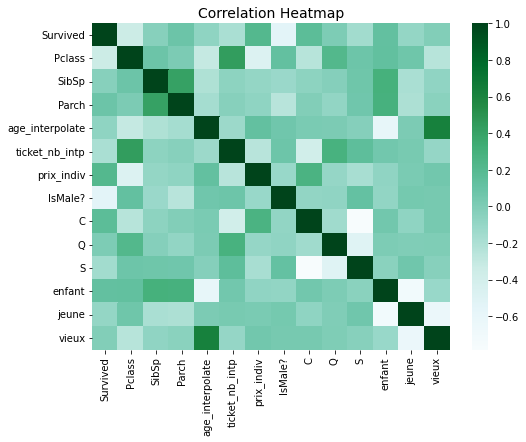

In [25]:
# Corrélation des variables
plt.figure(figsize=(8, 6))

_ = heatmap = sns.heatmap(data_finished_scalled.corr(), cmap = 'BuGn')
_ = heatmap.set_title('Correlation Heatmap', fontsize = 14)

Le niveau de survie semble fortement corrélé au sexe ainsi qu'à la classe sociale.

# Modelisation

On commence par diviser mon set de données en deux parties "train et test" :

In [26]:
# La matrice X correspond à l'ensemble de notre DataSet
X = data_finished_scalled.iloc[:,1:]

# On définit la cible càd est-ce que l'individu va survivre ?
y = data_finished_scalled['Survived']

# On divise le dataset en dataset d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 46)

# Détection de biais dans le Dataset
On va utiliser aif360

In [27]:
train_bld = BinaryLabelDataset(df=pd.concat((X_train, y_train),
                                               axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['IsMale?'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'IsMale?': -1}] # femmes
unprivileged_groups = [{'IsMale?': 0}] # hommes

In [28]:
class MetricAdditions:
    def explain(self,
                disp: bool=True) -> Union[None, str]:
        """Explain everything available for the given metric."""

        # Find intersecting methods/attributes between MetricTextExplainer and provided metric.
        inter = set(dir(self)).intersection(set(dir(self.metric)))

        # Ignore private and dunder methods
        metric_methods = [getattr(self, c) for c in inter if c.startswith('_') < 1]

        # Call methods, join to new lines
        s = "\n".join([f() for f in metric_methods if callable(f)])

        if disp:
            print(s)
        else:
            return s
        
        
class MetricTextExplainer_(MetricTextExplainer, MetricAdditions):
    """Combine explainer and .explain."""
    pass

In [29]:
metric_train_bld = BinaryLabelDatasetMetric(train_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

explainer = MetricTextExplainer_(metric_train_bld)
explainer.explain()

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.5654458598726115
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.23760108781220923
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.5654458598726115
Number of negative-outcome instances: 450.0
Number of positive-outcome instances: 261.0
Consistency (Zemel, et al. 2013): [0.78902954]
Number of instances: 711.0


Ces différentes métrics montrent toutes un biais en défaveur des hommes dans le data set.

Reweighting : On choisit de tester une methode de redressement pre-processing

In [30]:
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
train_bld_rw = rw.fit_transform(train_bld)

In [31]:
pd.DataFrame({'IsMale?': X_train['IsMale?'],
              'Survived': y_train,
              'Original_weight': np.ones(shape=(X_train.shape[0],)),
              'new_weight': train_bld_rw.instance_weights}).sample(15)

,IsMale?,Survived,Original_weight,new_weight
203,0.0,1.0,1.0,2.083117
426,-1.0,1.0,1.0,0.494951
817,0.0,0.0,1.0,0.768302
309,-1.0,1.0,1.0,0.494951
30,0.0,0.0,1.0,0.768302
329,-1.0,1.0,1.0,0.494951
821,0.0,0.0,1.0,0.768302
623,0.0,0.0,1.0,0.768302
580,-1.0,1.0,1.0,0.494951
42,0.0,0.0,1.0,0.768302


In [32]:
metric_train_bld_rw = BinaryLabelDatasetMetric(train_bld_rw,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

explainer_rw = MetricTextExplainer_(metric_train_bld_rw)
explainer_rw.explain()

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 1.1102230246251565e-16
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002
Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): 1.1102230246251565e-16
Number of negative-outcome instances: 450.00000000000006
Number of positive-outcome instances: 261.0
Consistency (Zemel, et al. 2013): [0.78902954]
Number of instances: 711.0


On voit que le reweignting a corrigé les mesures de biais dans le dataset

## Modèle directement interprétable : l'arbre de décision
### GridSearch
Je vais déterminer les hyperparamètres optimaux de mon modèle en utilisant la fonction GridSearch :

In [34]:
# Hyperparameters tunning
# On initie le modèle de type Arbre de décision
decision_tree = DecisionTreeClassifier(max_features = 'auto', random_state = 1)

# On définit les paramètres à déterminer par le GridSearch
param_grid = {"criterion" : ["gini", "entropy", "log_loss"],
              "max_depth" : [2, 3],
              "min_samples_leaf" : [1, 5, 10],
              "min_samples_split" : [2, 4, 10, 12, 16]}

# On lance le GridSearch
gs = GridSearchCV(estimator = decision_tree, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 8)
# Ensuite On fit le modèle
gs.fit(X_train, y_train)

GridSearchCV(cv=8,
             estimator=DecisionTreeClassifier(max_features='auto',
                                              random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3], 'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 4, 10, 12, 16]},
             scoring='accuracy')

In [35]:
# On affiche les résultats du GridSearch
print('meilleur estimateur :', gs.best_estimator_)
print('meilleur paramètres :', gs.best_params_)
print('meilleur score :', gs.best_score_)

meilleur estimateur : DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features='auto',
                       random_state=1)
meilleur paramètres : {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
meilleur score : 0.7960769918283963


### Courbes d'apprentissage
Maintenant qu'on a déterminé les meilleurs hyperparamètres pour le modèle, On veut s'assurer que ce modèle a appris correctement. On va représenter les courbes d'apprentissage grâce auxquelles on peut visualiser les éventuelles erreurs de prédiction selon la taille de mon dataset d'apprentissage :

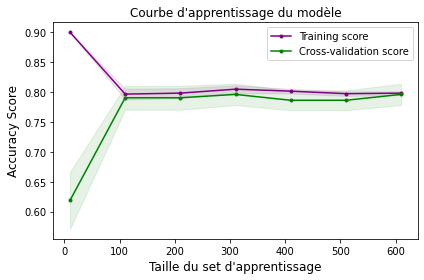

In [36]:
train_sizes,train_scores,test_scores = learning_curve(gs.best_estimator_,
                                                      X_train, 
                                                      y_train,
                                                      train_sizes = np.arange(10, 700, 100),
                                                      cv = 8)

# Je calcule les moyennes et les écarts types de mes data test et train
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

# Je plot les moyennes
plt.plot(train_sizes, train_scores_mean, '.-', color = "purple",
                 label = "Training score")
plt.plot(train_sizes, test_scores_mean, '.-', color = "g",
                 label = "Cross-validation score")

# Ainsi que les écarts types 
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha = 0.1,
                         color = "purple")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1,
                         color = "g")

_ = plt.title("Courbe d'apprentissage du modèle", fontsize = 12)
_ = plt.xlabel("Taille du set d'apprentissage", fontsize = 12)
_ = plt.ylabel("Accuracy Score", fontsize = 12)
_ = plt.legend(loc = "best", fontsize = 10)
_ = plt.tight_layout()

Au fur et à mesure de l'entrainement le taux d'erreur des deux courbes se stabilise. Le modèle semble adapté car les valeurs entre train et test sont comparables (on peut donc exclure de l'over ou underfitting).

### Arbre de décision
Grâce au GridSearch on a pu déterminer les meilleurs paramètres. On les applique sur l'arbre de décision :

In [38]:
# On fait appel au modèle de type Arbre de décision
decision_tree = DecisionTreeClassifier(criterion = 'entropy',
                                       max_depth = 2,
                                       min_samples_leaf = 1,
                                       min_samples_split = 2)

# Apprentissage = On fit le modèle sur les données 
decision_tree.fit(X_train, y_train)

# Prédiction du résultat du modèle
tree_prediction = decision_tree.predict(X_test) 

# On vérifie que notre modèle a bien été entraîné 
y_val = decision_tree.predict(X_train)

### Précision du modèle - Arbre de décision

In [39]:
# On récupère les scores
print('accuracy_score_train :', accuracy_score(y_train, y_val))
print('accuracy_score_test :', accuracy_score(y_test, tree_prediction))

accuracy_score_train : 0.7960618846694796
accuracy_score_test : 0.7471910112359551


### Courbe ROC et ROC AUC
On représente les performances du modèle de classification avec la courbe ROC :

In [41]:
# On calcule la probabilité de prédiction de mon arbre de décision
probas = decision_tree.predict_proba(X_test)

# Puis on renseigne les probabilités de prédire la survie pour tracer la courbe ROC 
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1], pos_label = 1)

# Et on calcule l'aire sous la courbe
roc_auc = roc_auc_score(y_test, probas[:,1])

On représente la courbe ROC ainsi que la matrice de confusion pour vérifier visuellement l'état du modèle : 

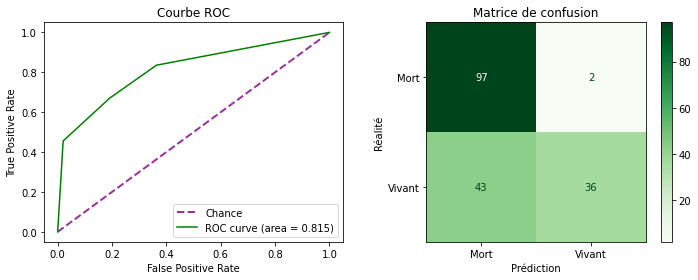

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# On plot la courbe ROC
_ = ax[0].plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'purple',
               label = 'Chance', alpha = .8)

_ = ax[0].plot(fpr,
               tpr,
               color = 'green',
               label = f"ROC curve (area = {round(roc_auc, 3)})")

_ = ax[0].set(title = 'Courbe ROC',
              xlabel = 'False Positive Rate',
              ylabel = 'True Positive Rate',)

_ = ax[0].legend(loc = "lower right")

# On plot la confusion matrix
cm = confusion_matrix(y_test, tree_prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels = ['Mort','Vivant'])
cmd.plot(ax = ax[1], cmap = 'Greens')

_ = plt.xlabel('Prédiction')
_ = plt.ylabel('Réalité')
_ = plt.title('Matrice de confusion')

plt.tight_layout()  

Le score de l'aire sous la courbe est relativement proche de 1, on considère donc que le modèle prédit correctement.
La matrice de confusion nous indique que nous avons 36 vrais positifs, 2 faux positifs, 97 vrais négatifs et 43 faux négatifs. Au regard de ces résultats, mon modèle semble adapté, même si le niveau de faux négatif est élevé.

### Evaluation des performances moyennes du modèle - Cross validation

De sorte à évaluer la performance moyenne du modèle, on repart du dataset de départ qu'on va splitter plusieurs fois (ici 5 fois). Ainsi, on va pouvoir calculer ensuite sur ces morceaux de dataset la performance du modèle au travers de l'accuracy (combien de fois le modèle était correct), de la précision (à quel point le modèle est bon pour prédire une catégorie spécifique), du recall (combien de fois le modèle a été capable de détecter une catégorie spécifique) et enfin de l'aire sous la courbe ROC :

In [43]:
# On sépare en 5 morceaux
kfold = KFold(n_splits = 5, 
              shuffle = True, 
              random_state = 46)

accuracies_list = []
precision_score_list = []
recall_score_list = []
roc_auc_list = []

# On réalise la cross validation
split = kfold.split(X)
for train_split, val_split in split:
    train_data = X.loc[train_split]
    val_data = X.loc[val_split]
    train_labels = y.loc[train_split]
    val_labels = y.loc[val_split]
    
    decision_tree.fit(train_data, train_labels)
    
    pred = decision_tree.predict(val_data)
    
    accuracies = accuracy_score(val_labels, pred)
    accuracies_list.append(accuracies)
    
    precision_score_ = precision_score(val_labels, pred)
    precision_score_list.append(precision_score_)
    
    recall_score_ = recall_score(val_labels, pred)
    recall_score_list.append(recall_score_)
    
    roc_auc = roc_auc_score(val_labels, pred)
    roc_auc_list.append(roc_auc)

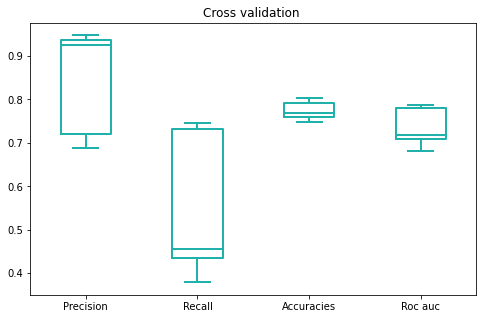

In [44]:
boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen', linewidth = 2)
whiskerprops = dict(color = 'lightseagreen', linewidth = 2)
capprops = dict(color = 'lightseagreen', linewidth = 2)

results = pd.DataFrame({'Precision' : precision_score_list,
                        'Recall' : recall_score_list,
                        'Accuracies' : accuracies_list,
                        'Roc auc' : roc_auc_list})

_ = results.plot(kind = 'box',
             title = 'Cross validation ',
             boxprops = boxprops, 
             whiskerprops = whiskerprops, 
             capprops = capprops, 
             medianprops = medianprops, 
                figsize = (8,5))

fig.tight_layout()

La cross-validation nous confirme qu'en moyenne les paramètres de précisions du modèle sont bons.

### Représentation du modèle : Arbre de décision

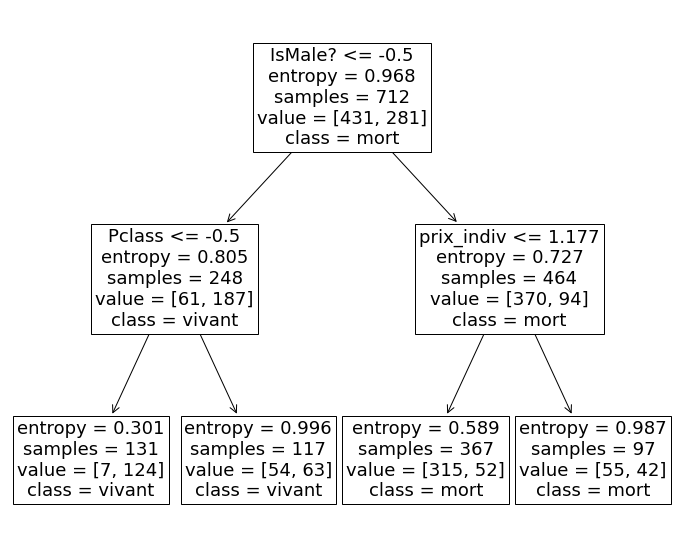

In [45]:
_ = plt.figure(figsize = (12, 10))
_ = tree.plot_tree(decision_tree,
                   feature_names =  X.columns,
                   class_names = ['mort', 'vivant'],
                   filled = False,
                   fontsize = 18)

Selon l'arbre de décision, le premier paramètre permettant de déterminer si une personne a survécu est le sexe. 
    Si la personne était une femme on regarde ensuite sa classe. Il semblerait que peut importe la classe les femmes survivent.
       Si la personne était un homme, le second paramètre a regarder serait le prix du ticket. Mais en somme, le simple fait d'être un homme fait que la personne va mourir.

### Vérification du biais
Au début de l'analyse, on a noté un biais de genre dans le dataset, la performance du modèle et son interprétation semble indiquer un effet fort du genre, nous allons vérifier si il y a un biais dans les prédictions :

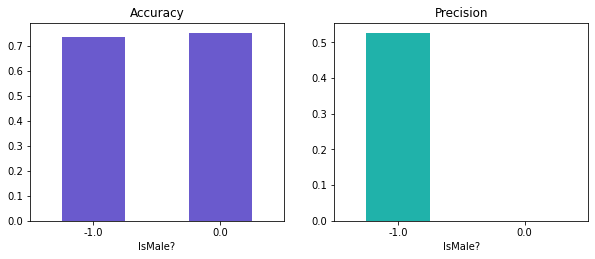

In [46]:
# Effet du biais selon librairie fairlearn concernant la variable sex :
metrics = {'Accuracy': accuracy_score,
           'Precision': selection_rate}

metric_frame = MetricFrame(metrics = metrics,
                           y_true = y_test,
                           y_pred = tree_prediction,
                           sensitive_features =  X_test['IsMale?'])

_ = metric_frame.by_group.plot.bar(subplots = True,
                                   color = {"Accuracy": "slateblue", 
                                            "Precision": "lightseagreen"},
                                   layout = [2,2],
                                   figsize = [10, 8],
                                   rot = 0,
                                   legend = False)

fig.tight_layout()

Quel que soit le sexe, le modèle est similairement "accurate".
Cependant, il y a un fort biais concernant la précision. 
Nous allons mesurer cet effet par le disparate impact ratio

In [47]:
# Mesure disparate impact ratio librairie aif360 sur les predictions :

test_bld = BinaryLabelDataset(df=pd.concat((X_test, y_test),
                                               axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['IsMale?'],
                                  favorable_label=1,
                                  unfavorable_label=0)

pred_bld = BinaryLabelDataset(df=pd.concat((X_test, pd.Series(tree_prediction,index=X_test.index, name='Survived')),axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['IsMale?'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'IsMale?': -1}] # femmes
unprivileged_groups = [{'IsMale?': 0}] # hommes

DT_metric_bias = ClassificationMetric(test_bld, pred_bld, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [48]:
print("Test set: Classification accuracy = {:.3f}".format(DT_metric_bias.accuracy()))
TPR = DT_metric_bias.true_positive_rate()
TNR = DT_metric_bias.true_negative_rate()
bal_acc_bias_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_bias_test))
print("Test set: Disparate impact = {:.3f}".format(DT_metric_bias.disparate_impact()))
fdr = DT_metric_bias.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

Test set: Classification accuracy = 0.747
Test set: Balanced classification accuracy = 0.718
Test set: Disparate impact = 0.000
Test set: False discovery rate ratio = 0.000


Nous pouvons observer un Disparate impact très important, en lien avec la precision observé plus haut.

# Voyons maintenant les performances en utilisant le reweighting

On utilise les mêmes hyperparamètres

In [73]:
# On fait appel au modèle de type Arbre de décision
rw_decision_tree = DecisionTreeClassifier(criterion = 'gini',
                                       max_depth = 4,
                                       min_samples_leaf = 4,
                                       min_samples_split = 4)

# On utilise les poids mesurés tout à l'heure 
rw_decision_tree.fit(X_train, y_train, sample_weight=train_bld_rw.instance_weights)

# Prédiction du résultat du modèle
rw_tree_prediction = rw_decision_tree.predict(X_test) 

# On vérifie que notre modèle a bien été entraîné 
rw_y_val = rw_decision_tree.predict(X_train)

In [74]:
# On récupère les scores
print('rw_accuracy_score_train :', accuracy_score(y_train, rw_y_val))
print('rw_accuracy_score_test :', accuracy_score(y_test, rw_tree_prediction))
print('accuracy_score_train :', accuracy_score(y_train, y_val))
print('accuracy_score_test :', accuracy_score(y_test, tree_prediction))

rw_accuracy_score_train : 0.7313642756680732
rw_accuracy_score_test : 0.6292134831460674
accuracy_score_train : 0.7960618846694796
accuracy_score_test : 0.7471910112359551


On voit une réduction des performances suite au reweignting. Regardons si nous avons réduit le nombre de faux négatifs

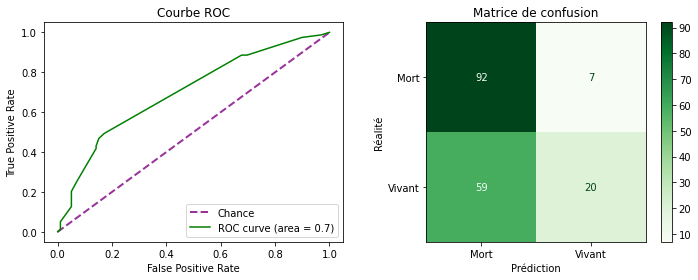

In [75]:
# On calcule la probabilité de prédiction de mon arbre de décision
rw_probas = rw_decision_tree.predict_proba(X_test)

# Puis on renseigne les probabilités de prédire la survie pour tracer la courbe ROC 
fpr, tpr, thresholds = roc_curve(y_test, rw_probas[:,1], pos_label = 1)

# Et on calcule l'aire sous la courbe
roc_auc = roc_auc_score(y_test, rw_probas[:,1])

fig, ax = plt.subplots(1, 2, figsize = (10,4))

# On plot la courbe ROC
_ = ax[0].plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'purple',
               label = 'Chance', alpha = .8)

_ = ax[0].plot(fpr,
               tpr,
               color = 'green',
               label = f"ROC curve (area = {round(roc_auc, 3)})")

_ = ax[0].set(title = 'Courbe ROC',
              xlabel = 'False Positive Rate',
              ylabel = 'True Positive Rate',)

_ = ax[0].legend(loc = "lower right")

# On plot la confusion matrix
cm = confusion_matrix(y_test, rw_tree_prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels = ['Mort','Vivant'])
cmd.plot(ax = ax[1], cmap = 'Greens')

_ = plt.xlabel('Prédiction')
_ = plt.ylabel('Réalité')
_ = plt.title('Matrice de confusion')

plt.tight_layout()  

On retrouve la baisse de performance ROC à 70% alors qu'elle était de 81% tout à l'heure, mais on ne voit pas d'amélioration du nombre de faux négatifs

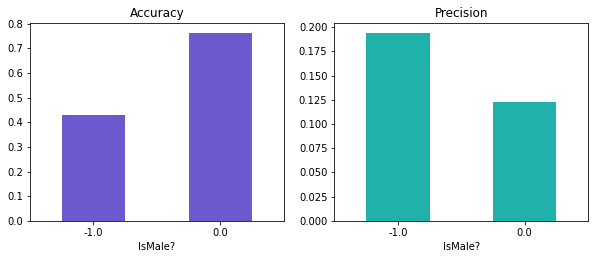

In [76]:
# Effet du biais selon librairie fairlearn concernant la variable sex :
metrics = {'Accuracy': accuracy_score,
           'Precision': selection_rate}

metric_frame = MetricFrame(metrics = metrics,
                           y_true = y_test,
                           y_pred = rw_tree_prediction,
                           sensitive_features =  X_test['IsMale?'])

_ = metric_frame.by_group.plot.bar(subplots = True,
                                   color = {"Accuracy": "slateblue", 
                                            "Precision": "lightseagreen"},
                                   layout = [2,2],
                                   figsize = [10, 8],
                                   rot = 0,
                                   legend = False)

fig.tight_layout()

On voit cependant, malgré la baisse d'accuracy, une meilleure précision pour les hommes

In [64]:
# Mesure disparate impact ratio librairie aif360 sur les predictions :

rw_pred_bld = BinaryLabelDataset(df=pd.concat((X_test, pd.Series(rw_tree_prediction,index=X_test.index, name='Survived')),axis=1),
                                  label_names=['Survived'],
                                  protected_attribute_names=['IsMale?'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'IsMale?': -1}] # femmes
unprivileged_groups = [{'IsMale?': 0}] # hommes

rw_DT_metric_bias = ClassificationMetric(test_bld, rw_pred_bld, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [65]:
print("Test set: Classification accuracy = {:.3f}".format(rw_DT_metric_bias.accuracy()))
TPR = rw_DT_metric_bias.true_positive_rate()
TNR = rw_DT_metric_bias.true_negative_rate()
bal_acc_bias_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = {:.3f}".format(bal_acc_bias_test))
print("Test set: Disparate impact = {:.3f}".format(rw_DT_metric_bias.disparate_impact()))
fdr = rw_DT_metric_bias.false_discovery_rate_ratio()
fdr = min(fdr, 1/fdr)
print("Test set: False discovery rate ratio = {:.3f}".format(fdr))

Test set: Classification accuracy = 0.657
Test set: Balanced classification accuracy = 0.639
Test set: Disparate impact = 0.897
Test set: False discovery rate ratio = 0.069


On voit clairement un rééquilibrage du biais de prédiction avec un Disparate impact proche de 1 (0 tout à l'heure)

# Modèle non directement interprétable 
### Random forest
Dans la seconde partie, on a choisi d'utiliser comme modèle non directement interprétable un random forest.

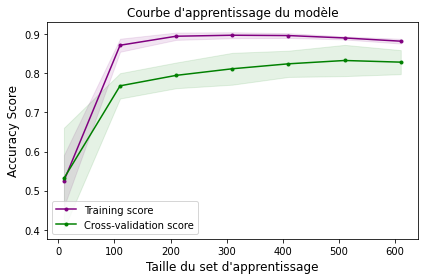

In [77]:
random_forest = RandomForestClassifier(criterion = 'gini',
                                       max_depth = 6,
                                       min_samples_leaf = 1,
                                       min_samples_split = 12,
                                       n_estimators = 100)

train_sizes,train_scores,test_scores = learning_curve(random_forest,
                                        X_train,
                                        y_train,
                                        train_sizes = np.arange(10, 700, 100),
                                        cv = 8)

# Je calcule les moyennes et les écarts types de mes data test et train
train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

# Je plot les moyennes
plt.plot(train_sizes, train_scores_mean, '.-', color = "purple",
                 label = "Training score")
plt.plot(train_sizes, test_scores_mean, '.-', color = "g",
                 label = "Cross-validation score")

# Ainsi que les écarts types 
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha = 0.1,
                         color = "purple")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1,
                         color = "g")


_ = plt.title("Courbe d'apprentissage du modèle", fontsize = 12)
_ = plt.xlabel("Taille du set d'apprentissage", fontsize = 12)
_ = plt.ylabel("Accuracy Score", fontsize = 12)
_ = plt.legend(loc = "best", fontsize = 10)
_ = plt.tight_layout()

Au fur et à mesure de l'entrainement le taux d'erreur des deux courbes se stabilise. Le modèle semble adapté car les valeurs entre train et test sont comparables (on peut donc exclure de l'over ou underfitting).

In [78]:
#Entrainement du RandomForest
random_forest = random_forest.fit(X_train, y_train)

# Prédiction du résultat du modèle
rf_prediction = random_forest.predict(X_test) 

# Je vérifie que notre modèle a bien été entraîné 
y_val = random_forest.predict(X_train)

### Précision du modèle - random forest

In [79]:
# Je récupère les scores
print('accuracy_score_train :', accuracy_score(y_train, y_val))
print('accuracy_score_test :', accuracy_score(y_test, rf_prediction))

accuracy_score_train : 0.8790436005625879
accuracy_score_test : 0.8033707865168539


La random forest donne des résultats meilleurs que l'arbre de décision

### Courbe ROC et ROC AUC
On représente les performances du modèle de classification avec la courbe ROC :

In [80]:
# Je calcule la probabilité de prédiction de mon random forest
rf_probas = random_forest.predict_proba(X_test)

# Puis je renseigne les probabilités de prédire la survie pour tracer la courbe ROC 
fpr, tpr, thresholds = roc_curve(y_test, rf_probas[:,1], pos_label = 1)

# Et je calcule l'aire sous la courbe
roc_auc = roc_auc_score(y_test, rf_probas[:,1])

On représente ma courbe ROC ainsi que la matrice de confusion pour vérifier visuellement l'état de mon modèle : 

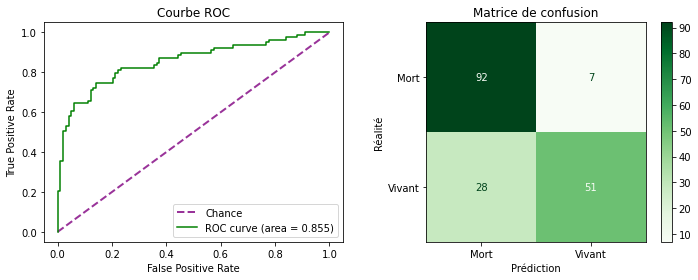

In [81]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

# Je plot la courbe ROC
_ = ax[0].plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'purple',
               label = 'Chance', alpha = .8)
_ = ax[0].plot(fpr,
               tpr,
               color = 'green',
               label = f"ROC curve (area = {round(roc_auc, 3)})")
_ = ax[0].set(title = 'Courbe ROC',
          xlabel = 'False Positive Rate',
          ylabel = 'True Positive Rate',)
_ = ax[0].legend(loc = "lower right")

# Je plot la confusion matrix
cm = confusion_matrix(y_test, rf_prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels = ['Mort','Vivant'])
cmd.plot(ax = ax[1], cmap = 'Greens')

_ = plt.xlabel('Prédiction')
_ = plt.ylabel('Réalité')
_ = plt.title('Matrice de confusion')

plt.tight_layout()

Le score de l'aire sous la courbe est relativement proche de 1, on considère donc que le modèle prédit correctement. 
La matrice de confusion nous indique que nous avons 49 vrais positifs, 7 faux positifs, 92 vrais négatifs et 30 faux négatifs. Au regard de ces résultats, le modèle semble adapté.

### Evaluation des performances du modèle - Cross validation

In [82]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 46)

accuracies_list = []
precision_score_list = []
recall_score_list = []
roc_auc_list = []

split = kfold.split(X)
for train_split, val_split in split:
    train_data = X.loc[train_split]
    val_data = X.loc[val_split]
    train_labels = y.loc[train_split]
    val_labels = y.loc[val_split]
    
    random_forest.fit(train_data, train_labels)
    
    pred = random_forest.predict(val_data)
    
    accuracies = accuracy_score(val_labels, pred)
    accuracies_list.append(accuracies)
    
    precision_score_ = precision_score(val_labels, pred)
    precision_score_list.append(precision_score_)
    
    recall_score_ = recall_score(val_labels, pred)
    recall_score_list.append(recall_score_)
    
    roc_auc = roc_auc_score(val_labels, pred)
    roc_auc_list.append(roc_auc)

On représente ces différents résultats : 

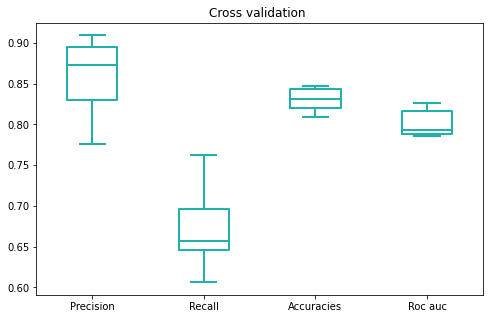

In [83]:
boxprops = dict(color = 'lightseagreen', linewidth = 2)
medianprops = dict(color = 'lightseagreen', linewidth = 2)
whiskerprops = dict(color = 'lightseagreen', linewidth = 2)
capprops = dict(color = 'lightseagreen', linewidth = 2)

results = pd.DataFrame({'Precision' : precision_score_list,
                        'Recall' : recall_score_list,
                        'Accuracies' : accuracies_list,
                        'Roc auc' : roc_auc_list})

_ = results.plot(kind = 'box',
             title = 'Cross validation ',
             boxprops = boxprops, 
             whiskerprops = whiskerprops, 
             capprops = capprops, 
             medianprops = medianprops, 
                figsize = (8,5))

fig.tight_layout()

La cross-validation nous confirme qu'en moyenne les paramètres de précisions du modèle sont bons.

### Interprétabilité modèle - Random forest

Le modèle de random forest n'est pas directement interprétable. On va donc regarder l'importance de chaque variable dans ce modèle en utilisant la méthode de Mean Decrease in Impurity (MDI) : 

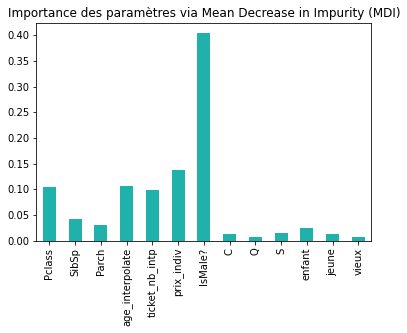

In [84]:
importances = random_forest.feature_importances_

random_forest_importances = pd.Series(importances, index = X.columns)

random_forest_importances.plot.bar(title = 'Importance des paramètres via Mean Decrease in Impurity (MDI)',
                                   color = 'lightseagreen')

fig.tight_layout()

Certains paramètres sont plus importants que d'autres (notamment le sexe). Toutefois, avec cette méthode on ne peux dire précisément l'effet de chaque variable sur le modèle. On va donc utiliser la librairie SHAP pour mieux visualiser et interpréter le résultat du random forest : 

  0%|          | 0/178 [00:00<?, ?it/s]

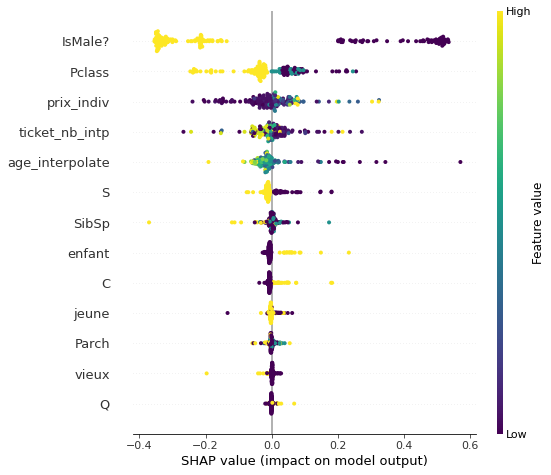

In [85]:
explainer = shap.KernelExplainer(random_forest.predict, X_test)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, cmap = 'viridis')

Les variables les plus importantes sont le sexe et la classe sociale. Le taux de survie baisse drastiquement lorsque l'on est un homme et ce d'autant plus que notre classe sociale est faible.
On peut voir cet analyse par individu : 

In [86]:
shap.initjs()
choosen_instance = X_test.loc[[2]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value, shap_values, choosen_instance)

  0%|          | 0/1 [00:00<?, ?it/s]

Ici, le passager a survécu. Le modèle de random forest a pu faire cette prédiction basé sur le fait que la personne était de sexe féminin, son age et son numéro de ticket.

En somme, le second modèle de random forest a l'air de mieux fonctionner que l'arbre de décision. Notamment au niveau de la précison qui est meilleure avec le random forest. Cependant cette méthode est non directement interprétable et on doit utiliser des outils complémentaires pour expliquer les résultats. 